In [10]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
class LinearRegression:
    def __init__(self, lr=0.01, num_iterations=500):
        self.lr = lr
        self.num_iterations = num_iterations
        self.W = None
        self.b = None

    def fit(self, X, y):
        num_targets = y.shape[1]
        num_features = X.shape[1]
        self.W = np.random.random((num_targets, num_features))
        self.b = np.random.random((num_targets, 1))

        self.cost_f = []

        for i in range(self.num_iterations):
            pred = X.dot(self.W.T) + self.b.T

            grad_W = -(2 / X.shape[0]) * (y - pred).T.dot(X)
            grad_b = -(2 / X.shape[0]) * np.sum(y - pred, axis=0, keepdims=True).T

            self.W -= self.lr * grad_W
            self.b -= self.lr * grad_b

            self.cost_f.append(np.mean((y - pred) ** 2))

    def predict(self, X):
        return X.dot(self.W.T) + self.b.T


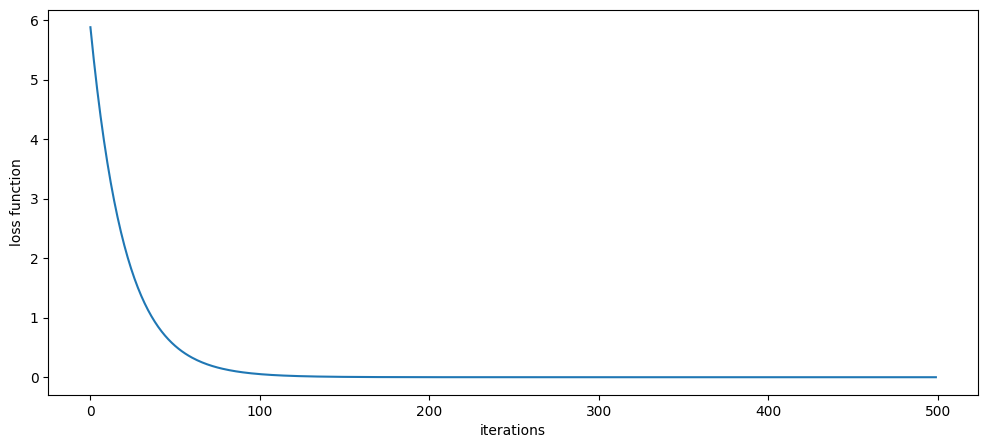

In [9]:
num_examples = 100
num_features = 3
num_targets = 2

X = np.random.randn(num_examples, num_features)
W_true = np.random.randn(num_targets, num_features)
b_true = np.random.randn(num_targets, 1)
y_true = X.dot(W_true.T) + b_true.T
noise = 0.3 * np.random.randn(num_examples, num_targets)
y = y_true + noise

linreg = LinearRegression()

linreg.fit(X, y_true)
# print(linreg.cost_f)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot([i for i in range(0, len(linreg.cost_f))], linreg.cost_f)
ax.set_xlabel('iterations')
ax.set_ylabel('loss function')

plt.show()

In [25]:
class Sigmoid:
    def __call__(self, x):
        return 1 / (1 + np.exp(-x))

    def backward(self, arr):
        np.array([self.__call__(el) for el in arr])

class Relu:
    def __call__(self, x):
        return np.maximum(0, x)

    def backward(self, x):
        return (x > 0).astype("float")


class BCELoss:
    def forward(self, predict, y):
        p = sigmoid_for_el(predict)
        return -1 * (y * np.log(p + 1e-5) + (1 - y) * np.log(1 - p + 1e-5))

    def backward(self, predict, y):
        p = sigmoid_for_el(predict)
        return np.expand_dims(p - y, -1)


class LinearLayer:
    def __init__(self, w, b):
        self.w = w
        self.b = b
        self.grad_w = None
        self.grad_b = None
        self.activation = Relu()
        self.last_input = None
        self.last_out = None

    def calc(self, x):
        self.last_input = x
        out = x @ self.w + self.b
        if self.activation:
            self.last_out = out
            out = self.activation(out)

        return out

    def backward(self, grad):
        if self.activation:
            grad = np.multiply(grad, self.activation.backward(self.last_out))

        self.grad_w = np.transpose(self.last_input) @ grad
        self.grad_b = np.sum(grad, axis=0)
        return grad @ np.transpose(self.w)

    def weights_update(self, alpha=1e-2):
        self.w = self.w.astype("float64")
        self.w -= alpha * self.grad_w
        self.b = self.b.astype("float")
        self.b -= alpha * self.grad_b


class MLPRegressor:
    def __init__(self, x_input, layers_dims, loss_function=None):
        """
        :param x_input:
        :param layers_count:
        :param loss_function:
        """

        self.layers_count = len(layers_dims)
        self.loss_function = loss_function
        self.input_size = len(x_input[0])
        self.layers_dims = layers_dims
        self.weights, self.bias = self.initialize_parameters(self.layers_dims)
        self.x_input = x_input
        self.hidden_layer = np.array(
            [LinearLayer(self.weights[i], self.bias[i]) for i in range(len(self.weights))]
        )

    def initialize_parameters(self, layer_dims):
        length = len(layer_dims)
        w = [np.random.normal(loc=0, scale=0.2, size=(layer_dims[i - 1], layer_dims[i])) for i in range(1, length)]
        b = [np.zeros((1, layer_dims[i])) for i in range(1, length)]
        return w, b

    def forward_pass(self, x):
        layer_output = x
        for layer in self.hidden_layer:
            layer_output = layer.calc(layer_output)
        return layer_output.ravel()

    def backward_pass(self, p, y, loss_function):
        loss = loss_function()
        loss_value = loss.forward(p, y)
        grad = loss.backward(p, y)
        for layer in reversed(self.hidden_layer):
            grad = layer.backward(grad)
            layer.weights_update()

        return loss_value


def sigmoid(x):
    return 1 / (1 + math.exp(-x + 1e-5))


def sigmoid_for_el(arr):
    return np.array([sigmoid(el) for el in arr])

In [29]:
N = 200
N2 = 25

n_pos = int(N // 2 + np.random.randint(-N2, N2))
n_neg = int(N // 2 + np.random.randint(-N2, N2))

pos_x = 1
pos_y = 1

neg_x = -1
neg_y = -1

pos_pairs = np.array([np.array(
    [pos_x + np.random.normal(scale=0.2), pos_y + np.random.normal(scale=0.2)])
    for i in range(0, n_pos)])

pos_answers = np.array([1] * n_pos)

neg_pairs = np.array([np.array(
    [neg_x + np.random.normal(scale=0.2), neg_y + np.random.normal(scale=0.2)]) for i in range(0, n_neg)]
)
neg_answers = np.array([0] * n_neg)

x = np.vstack([pos_pairs, neg_pairs])
y = np.hstack([pos_answers, neg_answers])

network = MLPRegressor(x, [len(x[0]), 20, 10, 5, 1])

for i in range(50):
    a = network.forward_pass(x)
    loss_w = BCELoss
    back = network.backward_pass(a, y, loss_function=loss_w)
print("loss =", back)

# for el in network.hidden_layer:
#     print("w =", el.w)
#     print("b =", el.b)
print("forward_pass =", sigmoid_for_el(network.forward_pass([[-1, -1], [1, 1]])))

loss = [1.57540670e-04 2.58998546e-04 1.91609267e-04 1.48800602e-04
 1.11550954e-04 8.29280125e-04 1.55597862e-04 3.80925223e-04
 2.73802028e-04 9.08039504e-05 1.30428226e-04 3.72745065e-04
 2.04591040e-04 5.22483069e-04 4.07481784e-04 2.85779493e-04
 2.07038414e-04 6.52382172e-04 2.29515857e-04 1.90195930e-04
 1.91487003e-04 5.80518993e-05 1.36997770e-04 1.58045249e-04
 1.34504098e-04 7.47403608e-04 1.44542533e-04 3.31614666e-04
 1.49018692e-04 3.81310850e-04 3.03352579e-04 3.47692860e-04
 1.84234311e-04 1.78777802e-04 3.06906787e-04 5.56090879e-04
 2.43078472e-04 1.95414534e-04 4.63847256e-04 1.77460679e-04
 9.49005751e-05 3.28085222e-04 1.27918868e-04 4.10453946e-04
 4.01959250e-04 6.05946287e-05 5.04417233e-04 8.26228779e-04
 8.44377663e-05 2.35192417e-04 1.28038679e-04 2.08323601e-04
 2.63105528e-04 9.86575968e-05 1.30257417e-03 1.76393618e-04
 1.02955132e-04 1.98141623e-04 3.91885153e-04 2.60506729e-04
 2.90166195e-04 5.69083175e-04 3.24987076e-04 2.56265087e-04
 4.82163933e-04 9